# Explore the consensus accuracy while downsampling reads
---


In [38]:
import os
import sys
import configparser
import getopt
import numpy as np
import pandas as pd
from collections import Counter

from lib.error import *

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# inline stylization
%matplotlib inline
sns.set_style('white')
sns.set_style('ticks')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['figure.figsize'] = [4, 4]

## 0 Settings

In [40]:
expt_dir = "../analysis/ont/zambia/2019-04-10/downsampling"  # experiment of interest

If `save_figs` is set to `True`, then figures are automatically saved as `.png` under `../figs`, as well as visualized in the notebook.

In [41]:
save_figs = True
fig_dir = expt_dir.replace("analysis", "figs")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [42]:
print("Make Figures:", save_figs)
print("Figure path:", fig_dir)

Make Figures: True
Figure path: ../figs/ont/zambia/2019-04-10/downsampling


## 1 Load downsampled data

In [43]:
fns = [f for f in os.listdir(expt_dir) if "error_freqs" in f]

In [44]:
error_dfs = []
for fn in fns:
    if "reverse" in fn:
        ix = 3
    else:
        ix = 2
    n_reads = int(fn.split(".")[ix][:-6])
    rep = int(fn.split(".")[-2])
    df = pd.read_csv(os.path.join(expt_dir, fn))
    df["n_reads"] = n_reads
    df["rep"] = rep
    error_dfs.append(df)

In [45]:
error_df = pd.concat(error_dfs, 0).sort_values(["n_reads", "rep"])
error_df["call_indel"] = error_df[["A", "T", "C", "G", "-"]].idxmax(1)
error_df["call_noindel"] = error_df[["A", "T", "C", "G"]].idxmax(1)

In [46]:
error_df["correct_indel"] = error_df["ref"] == error_df["call_indel"]
error_df["correct_noindel"] = error_df["ref"] == error_df["call_noindel"]

## 2 Compute statistics and plot

In [47]:
grps = error_df.groupby(["n_reads", "rep"])
n_reads = list(grps.mean().groupby("n_reads").groups)

# mean coverage/accuracy for each replicate, then mean of that:
means = grps.mean().groupby("n_reads").mean()

# mean coverage/accuracy for each replicate, then std across replicates:
stds = grps.mean().groupby("n_reads").std()

### 2a Mean

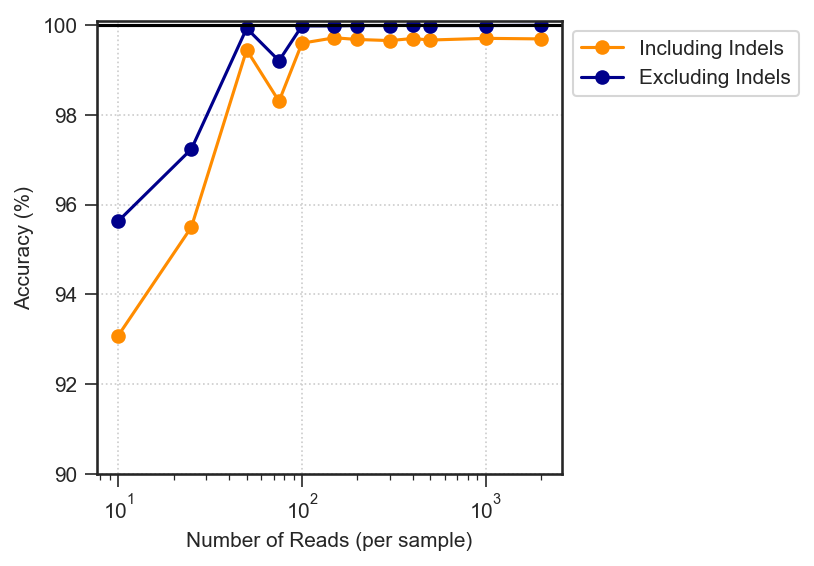

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot
ax.plot(n_reads, 100*means.correct_indel, 
        'o-', color="darkorange", label='Including Indels')
ax.plot(n_reads, 100*means.correct_noindel, 
        'o-', color="darkblue", label='Excluding Indels')
# Limits
ax.set_ylim((90, 100.1))
# Scale
ax.set_xscale("log")
# Lines
ax.axhline(y=100, color='black')
ax.grid(linestyle='dotted')

# Labels
ax.set_xlabel("Number of Reads (per sample)")
ax.set_ylabel("Accuracy (%)")
# Legend
ax.legend(bbox_to_anchor=(1,1), frameon=True)

if save_figs:
    fig.savefig(os.path.join(fig_dir, "lineplot_means.png"),
                bbox_inches="tight",
                pad_inches=0.5)

Why does 75 dip? Repeat with more replicates obviously. Or maybe a swarmplot is nice.

### 2b Swarmplots

In [49]:
df = grps.mean()
df["n_reads"] = df.index.get_level_values("n_reads")

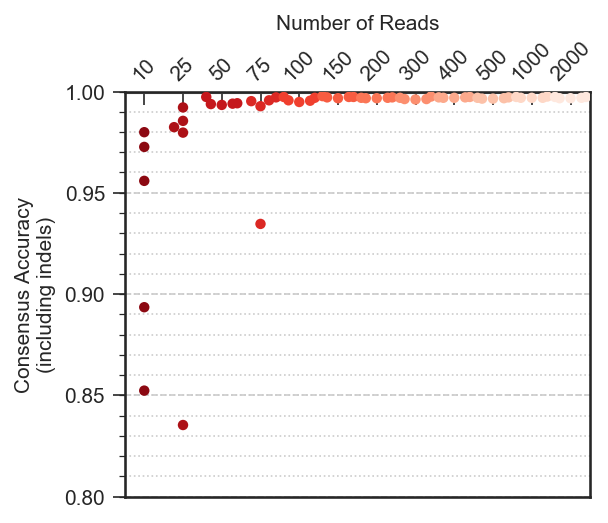

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.subplots_adjust(top=0.8)

sns.set_palette("Reds_r", len(n_reads))
sns.swarmplot(x="n_reads", 
              y="correct_indel",
              data=df, ax=ax)
# Limits
ax.set_ylim((0.8, 1.0))
# Clearer with x axis on top
ax.xaxis.tick_top()
ax.tick_params(axis="x", direction="in")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_label_position('top')
# Grid
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.grid(axis='y', linestyle='dashed')
ax.grid(axis='y', linestyle='dotted', which='minor')
# Lines
ax.axhline(y=1.0, color="grey", linestyle="solid", zorder=2)
# Labels
ax.set_xlabel("Number of Reads")
ax.set_ylabel("Consensus Accuracy\n(including indels)")

if save_figs:
    fig.savefig(os.path.join(fig_dir, "swarmplot_including_indels.png"),
                bbox_inches="tight",
                pad_inches=0.5)

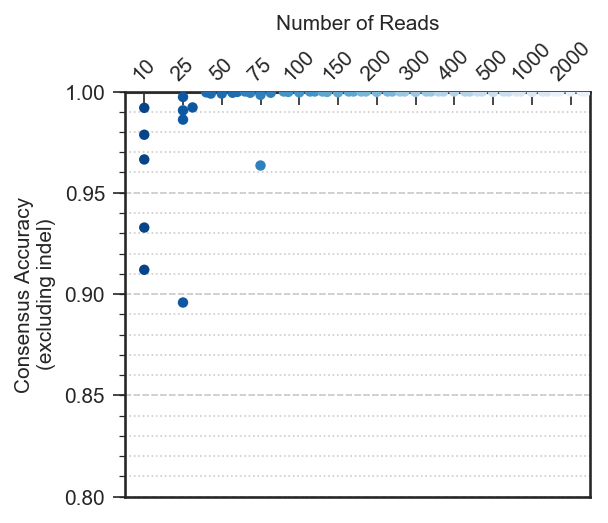

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.subplots_adjust(top=0.8)

sns.set_palette("Blues_r", len(n_reads))
sns.swarmplot(x="n_reads", 
              y="correct_noindel",
              data=df, ax=ax)

# Limits
ax.set_ylim((0.8, 1.0))
# Clearer with x axis on top
ax.xaxis.tick_top()
ax.tick_params(axis="x", direction="in")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_label_position('top')
# Grid
ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
ax.grid(axis='y', linestyle='dashed')
ax.grid(axis='y', linestyle='dotted', which='minor')
# Lines
ax.axhline(y=1.0, color="grey", linestyle="solid", zorder=2)
# Labels
ax.set_xlabel("Number of Reads")
ax.set_ylabel("Consensus Accuracy\n(excluding indel)")

if save_figs:
    fig.savefig(os.path.join(fig_dir, "swarmplot_excluding_indels.png"),
                bbox_inches="tight",
                pad_inches=0.5)

With 100 reads, the consensus accuracy looks perfect across all four genes.

## 3 Plot coverage

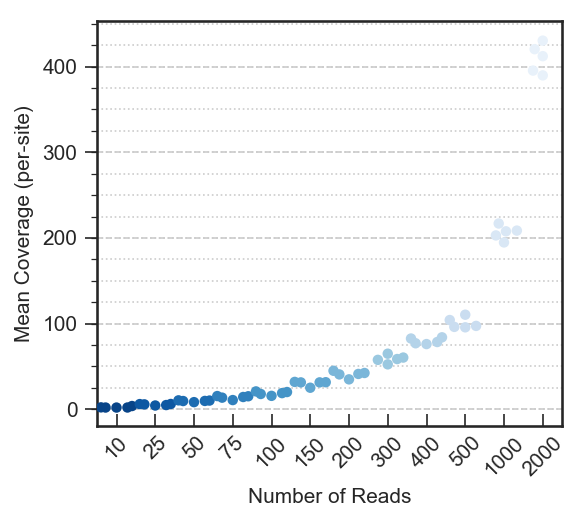

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
fig.subplots_adjust(top=0.8)

sns.set_palette("Blues_r", len(n_reads))
sns.swarmplot(x="n_reads", 
              y="total",
              data=df, ax=ax)

# Clearer with x axis on top
# ax.xaxis.tick_top()
ax.tick_params(axis="x", direction="in")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# ax.xaxis.set_label_position('top')
# Grid
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
ax.yaxis.set_minor_locator(plt.MultipleLocator(25))
ax.grid(axis='y', linestyle='dashed')
ax.grid(axis='y', linestyle='dotted', which='minor')
# Scale
#ax.set_yscale('log')
# Lines
#ax.axhline(y=1.0, color="grey", linestyle="solid", zorder=2)
# Labels
ax.set_xlabel("Number of Reads")
ax.set_ylabel("Mean Coverage (per-site)")

if save_figs:
    fig.savefig(os.path.join(fig_dir, "swarmplot_mean_coverage.png"),
                bbox_inches="tight",
                pad_inches=0.5)